In [1]:
# Reproduction of the simulation presented in
# "Wealth redistribution in our small world" (Iglesias et al., 2003, Physica A)
# with additional binary variables representing type of economic activity
# and the legality or repression of it.

# Graph theory library
# https://igraph.org/r/
library(igraph)

# A consistent, simple and easy to use set of wrappers around the fantastic 'stringi' package
# https://www.rdocumentation.org/packages/stringr/versions/1.4.0
library(stringr)

# Provides the nlsLM function, which works better than nls
# https://cran.r-project.org/web/packages/minpack.lm/index.html
library(minpack.lm)



Attaching package: ‘igraph’


The following objects are masked from ‘package:stats’:

    decompose, spectrum


The following object is masked from ‘package:base’:

    union




In [2]:
# WR binary simulation results analysis:

wr_analysis <- function(x_str, y_str, aa0, x0, dx0, lowerlimits, upperlimits)
{

erf <- function(x) 2 * pnorm(x * sqrt(2)) - 1

x = as.numeric(unlist(str_extract_all(x_str, "[\\.0-9e-]+")))
y = as.numeric(unlist(str_extract_all(y_str, "[\\.0-9e-]+")))
    
cat("\n")
cat("\n In wr_analysis:")
cat("\n x = ",x)
cat("\n y = ",y)
    
plot(x,y,type="h",xlim=c(0,1))

hdataframe = data.frame(x = x, y = y)

# Estimate some starting values:

aa.0 = aa0
dx.0 = dx0
x0.0 = x0

cat("\n")
cat("\n Initial parameters for curve fitting:")
cat("\n aa = ",aa.0,"\n dx = ",dx.0,"\n x0 = ",x0.0)

# Plot initial fit:
xfit.0 = seq(from=0.0, to=1.0, length.out=100)
yfit.0 = aa.0 * dlnorm((xfit.0-x0.0)/dx.0)
    
lines(xfit.0, yfit.0, col="green", lwd=3)

# Define limits:
    
lowerlimits = c(0.1*aa.0, 0.1*dx.0, 0.1*x0.0)
upperlimits = c(5.0*aa.0, 5.0*dx.0, 5.0*x0.0)
    
# Do the fit:

#try
#(

    fit <- nlsLM( y ~ aa * dlnorm((x-x0)/dx), data = hdataframe,
             start = list(aa = aa.0, dx = dx.0, x0 = x0.0),
             lower = lowerlimits,
             upper = upperlimits,
             alg = "plinear")
        
    xfit.1 = xfit.0
    yfit.1 = predict(fit, data.frame(x=xfit.0, y=yfit.0))
    
    cat("\n Still in wr_analysis:")
    cat("\n xfit.1 = ",xfit.1)
    cat("\n yfit.1 = ",yfit.1)    
    
    lines(xfit.1, yfit.1, col="blue", lwd=2)

    flush.console()

    aa = coef(fit)[[1]]
    dx = coef(fit)[[2]]
    x0 = coef(fit)[[3]]

    cat("\n")
    cat("\n Final adjusted parameters:")
    cat("\n aa = ",aa,"\n x0 = ",x0,"\n dx = ",dx)
    cat("\n")

#)

par(mar=c(5,6,4,1)+.1) # margins

plot(x, y, type="h", col="#00AAFF", lend=1, xlim=c(0,1), lwd=20, xlab="Wealth", ylab="Number of agents", cex=5, cex.lab=2, cex.axis=2)

f_sol = function(x) ( aa * dlnorm((x-x0)/dx) )  # divided by y_sum to normalize number of agents to 1
curve(f_sol, 0, 1, type="l", col="black", lwd=5, add=TRUE)


flush.console()
}

In [3]:
# WR binary simulation:

wr_binary_simulation <- function(n_agents, n_iter, n_bits, k, tol_n_irreg_bits, p_pun, f_pun, even_redist, wealth_prod, wealth_prod_per_con_per_iter, hist_breaks, debug, stop)
{
    # Printing input parameters:
    
    cat("\n Program WR")
    cat("\n")
    cat("\n Simulation initiated with the following parameters:")
    cat("\n Number of agents: n_agents = ",n_agents)
    cat("\n Number of iterations: n_iter = ",n_iter)
    cat("\n Number of bits of activity representation: n_bits = ",n_bits)
    cat("\n Connection range (half the vertex degree) k = ",k)
    cat("\n Tolerance of number of irregular bits: tol_n_irreg_bits = ", tol_n_irreg_bits)
    cat("\n Punishment probability: p_pun = ",p_pun)
    cat("\n Punishment force: f_pun = ",f_pun)
    cat("\n     (Fraction of wealth subtracted from punished agent.)")
    cat("\n Even wealth redistribution: even_redist = ",even_redist)
    cat("\n Wealth production: wealth_prod = ", wealth_prod)
    cat("\n Wealth produced per connection per iteration: wealth_prod_per_con_per_iter = ", wealth_prod_per_con_per_iter)
    cat("\n Number of histogram bars: hist_breaks = ",hist_breaks)
    cat("\n Program debug information: debug = ",debug)
    cat("\n Program stops: stop = ",stop)
    cat("\n")
    
    # Variable definition:
    
    w = vector(length = n_agents) # wealth of the agents
    u = matrix(sample(c(-1, 1), n_agents*n_bits, replace=TRUE), nrow = n_agents, ncol = n_bits) # activity orientation of the agents
    varmax_n_bits = vector(length = n_agents) # maximum u variation in bits
    A = matrix(0, nrow = n_agents, ncol = n_agents) # actual connections (adjacency matrix)
    P_con = matrix(0, nrow = n_agents, ncol = n_agents) # probability of connection
    
    n_neighbors = vector(length = n_agents) # number of neighbors of the agents
    total_n_neighbors = 0 # number of neighbors
    
    # Variable initiation:
    
    w = runif(n_agents, 0.0, 1.0) # generates n numbers between 0.0 and 1.0
    # u already initiated
    # A already initiated with zeros
    varmax_n_bits = replicate(n_agents, trunc(0.25*n_bits))
    # P_con already initiated with zeros
    d_varmax_n_bits = replicate(n_agents, trunc(0.1*n_bits))
       
    if (debug)
    {
        cat("\n u: ")
        print(u)
        cat("\n varmax_n_bits: ", varmax_n_bits)
        flush.console()
    }
    
    # Creating initial network:
    cat("\n Creating initial network...")
    
    ## Connecting each agent to its 2k closest neighbors:

    for (i in 1:n_agents-1)
    {
        for (j in (i-k):(i+k))
        {
            # Cyclic boundary conditions:
            
            j1 = j
            if(j1 < 1){j1 = j + n_agents}
            if(j1 > n_agents){j1 = j - n_agents}
            
            # Connecting i to the neighbors:
            
            # cat(i, j1, "\n") # debug
            if(i != j1)
            {
                A[i,j1] = 1
                A[j1,i] = 1
            }
            
        }
    }
    
    if(debug)
    {
        cat("\n")
        print(A)
        cat("\n")
    }
    
    ## Creating a graph from adjacency matrix A:

    A_graph = graph_from_adjacency_matrix(A, mode = "undirected")
    
    plot(A_graph, main = "agent graph before simulation")
    
    ## Creating sequence of vertices of the graph:

    v_A_graph = V(A_graph)
        
    # Creating files before main loop:
    
    file.create("varmax_n_bits-vs-iter.txt", showWarnings = TRUE)
    
    # MAIN LOOP:
    
    cat("\n Performing iterations...")
    cat("\n")
    
    for (iter in (1:n_iter))
    {
        if (debug)
        {
            cat("\n")
            cat("\n sum(w) = ", sum(w))
        }
        
        # Printing progress information:
        
        if ( ( iter %% (n_iter/10) ) == 0 )
        {
            cat("\n")
            cat("\n Now on iteration ",iter," of ",n_iter,".")
            cat("\n")
            flush.console()
        }

        # Generating wealth proportional to each agent's number of connections:
        
        if (wealth_prod)
        {
            for (i_agent in (1:n_agents))
            {
                n_neighbors_iagent = neighbors(A_graph, i_agent)
                
                if ( is.numeric(n_neighbors_iagent[[1]]) )
                {
                    w[i_agent] = w[i_agent] + 1.0*wealth_prod_per_con_per_iter*n_neighbors_iagent[[1]]
                }
                else
                {
                    cat("\n Variable with invalid value:")
                    cat("\n n_neighbors_iagent[[1]] = ", n_neighbors_iagent[[1]])
                    quit()
                }
            }
        }
        
        # Initialization of total loss of society wealth due to punishments:
        
        dw_pun = 0.0
               
        # Punishment of agents that do not conform to the rules of society:
        
        for (i_agent in (1:n_agents))
        {        
            # Counting number of irregular bits of the agent:
            
            n_irreg_bits = 0
            
            for (i_bit in (1:n_bits))
            {
                if (u[i_agent,i_bit] == -1)
                {
                    n_irreg_bits = n_irreg_bits + 1
                }
            }

            # Drawing a random number to define if the agent will be punished:
            
            rand1 = runif(1, 0.0, 1.0)
            
            # Checking if agent "i_agent" deserves to be punished,
            # based on nonconformity and chance:
            
            if( (n_irreg_bits > tol_n_irreg_bits) & (rand1 < p_pun)  )
            {
                # Defining punishment of the agent:
                
                w_pun_iagent = w[i_agent]*f_pun
                
                # Performing the punishment:
                
                w[i_agent] = w[i_agent] - w_pun_iagent
                              
                # Incrementing the total loss of society wealth due to punishments:

                dw_pun = dw_pun +  w_pun_iagent

                if (debug)
                {
                    cat("\n")
                    cat("\n i_agent, dw_pun ", i_agent, dw_pun)
                }
                
                # Changing maximum orientation variation accordingly:
                
                varmax_n_bits[i_agent] = varmax_n_bits[i_agent]*(1.0+f_pun)
                
                if (debug)
                {
                    cat("\n")
                    cat("\n f_pun ", f_pun)
                    cat("\n i_agent ", i_agent)
                    cat("\n varmax_n_bits[i_agent] ", varmax_n_bits[i_agent])
                    cat("\n n_bits ", n_bits)
                    cat("\n varmax_n_bits[i_agent] > n_bits ", varmax_n_bits[i_agent] > n_bits)
                    cat("\n")
                }
                
                ## Applying boundary conditions:

                if ( varmax_n_bits[i_agent] > n_bits )
                {
                        varmax_n_bits[i_agent] = n_bits
                }
                else
                {
                    if ( varmax_n_bits[i_agent] < 1 )
                    {
                        varmax_n_bits[i_agent] = 1
                    }
                }
                
                # Redefining a number varmax_n_bits of bits of the activity of each agent
                # (the redefinition is random and some bits will get the same value as before;
                # also, the same agent may be changed more than once):
                
                for (i_varied_bit in 1:varmax_n_bits[i_agent])
                {
                    irand = ceiling(runif(1,0,n_bits))
                    u[i_agent,irand] = sample(c(-1,1), 1, replace=TRUE)
                }
                
            } #if(rand1 < p_pun)

        } #for (i_agent in (1:n))
        
        # Redistributing the value raised in punishments:

        if(even_redist)
        {   
            # Even redistribution:
            
            for (i_agent in (1:n_agents))
            {
                if ( is.numeric(n_agents) && is.numeric(dw_pun) )
                {
                    if (debug)
                    {
                        cat("\n")
                        cat("\n i_agent ", i_agent)
                        cat("\n w[i_agent] antes: ", w[i_agent])
                    }
                    
                    w[i_agent] = w[i_agent] + dw_pun/n_agents
                    
                    if (debug)
                    {
                        cat("\n w[i_agent] depois: ", w[i_agent])
                        cat("\n")
                        cat("\n n_agents, dw_pun/n_agents ", n_agents, dw_pun/n_agents)
                    }
                    
                    #if (stop)
                    #{
                    #    invisible(readline(prompt="Press any key to continue"))
                    #}

                }
                else
                {
                    cat("\n Invalid variable value:")
                    cat("\n n_agents = ", n_agents)
                    cat("\n dw_pun = ", dw_pun)
                    quit()
                }
            }
        }
        else
        {
            # Redistribution proportional to each agent number of connections:

            total_n_neighbors = 0
            for (i_agent in (1:n_agents))
            {
                n_neighbors[[i_agent]] = length(neighbors(A_graph, i_agent))
                total_n_neighbors = total_n_neighbors + n_neighbors[[i_agent]]
            }
            
            for (i_agent in (1:n_agents))
            {                
                if ( is.numeric(n_neighbors[[i_agent]]) && is.numeric(total_n_neighbors) && is.numeric(dw_pun) )
                {
                    w[[i_agent]] = w[[i_agent]] + dw_pun*(n_neighbors[[i_agent]]/total_n_neighbors)
                }
                else
                {
                    cat("\n Invalid variable value:")
                    cat("\n n_neighbors_iagent[[1]] = ", n_neighbors[[i_agent]])
                    cat("\n gsize(A_graph) = ", gsize(A_graph))
                    cat("\n dw_pun = ", dw_pun)
                    # invisible(readline(prompt="Press any key to continue"))
                    quit()
                }
            }
        }
        
        # Printing iteration number:
        
        if (debug)
        {
            cat("\n")
            cat("\n Iteration ",iter)
            cat("\n")
            flush.console()
        }
        
        # Agent with minimum wealth will take an action...
        # Let's identify this agent:
        
        w_min = min(w) # minimum wealth
        i_w_min = which.min(w) # index of minimum wealth agent

        # Reporting:
        
        if (debug)
        {
            cat("\n w_min = ", w_min)
            cat("\n i_w_min = ", i_w_min)
            flush.console()
        }
        
        if (stop) {invisible(readline(prompt="\n Press any key to continue."))}
        
        # Calculating maximum wealth:
        
        w_max = max(w)
        
        # Changing the wealth of mininum wealth agent:
        
        if (wealth_prod)
        {
            w_new = runif(1, 0.0, w_max)
        }
        else
        {
            w_new = runif(1, 0.0, 1.0) # new random wealth
        }
        
        d_w = w_new - w_min # wealth variation of agent i_w_min
        
        # Calculating mean wealth:
        
        w_mean = mean(w)
        
        # Adjusting maximum variation of economic orientation:
               
        if ( w_min < 0.1*abs(w_mean) )
        {
            varmax_n_bits[i_w_min] = n_bits
        }
        else
        {
            varmax_n_bits[i_w_min] = varmax_n_bits[i_w_min] - ceiling(n_bits*d_w/w_min) # /n_iter
            # cat("\n ceiling(n_bits*d_w/w_min) = ",ceiling(n_bits*d_w/w_min))
            # invisible(readline(prompt="\n Press any key to continue."))
        }
              
        # Applying boundary conditions:
        
        if (debug)
        {
            cat("\n i_w_min = ", i_w_min)
            cat("\n w_min = ", w_min)
            cat("\n n_bits = ", n_bits)
            cat("\n varmax_n_bits[i_w_min] = ", varmax_n_bits[i_w_min])
            cat("\n varmax_n_bits[i_w_min] > n_bits = ", varmax_n_bits[i_w_min] > n_bits)
            cat("\n")
            cat("\n varmax_n_bits = ", varmax_n_bits)
            cat("\n")
        }
        
        if ( varmax_n_bits[i_w_min] > n_bits )
        {
            varmax_n_bits[i_w_min] = n_bits
        }
        else
        {
            if ( varmax_n_bits[i_w_min] < 1 )
            {
                varmax_n_bits[i_w_min] = 1
            }
        }
        
        # Actually changing the wealth of agent i_w_min:
        
        w[[i_w_min]] = w_new

        # Reporting:
        
        if (debug)
        {
            cat("\n w_new = ", w_new)
            cat("\n d_w = ", d_w)
            flush.console()
        }
        
        # Simplification of the graph to avoid multiple connections and loops:
        
        A_graph <- A_graph %>% simplify(remove.multiple = TRUE, remove.loops = TRUE, edge.attr.comb = igraph_opt("edge.attr.comb"))

        # The wealth variation of agent i_w_min will be compensated by its neighbors:
        
        neighbors_i_w_min = neighbors(A_graph, i_w_min) # neighbors of agent i_w_min
        n_neighbors = length(neighbors_i_w_min) # number of these neighbors
        
        if( is.numeric(n_neighbors[[1]]) )
        {
            d_w_neighbors = -d_w/n_neighbors[[1]] # variation of wealth of each neighbor
        }
        else
        {
            # If i_w_min is not connected, it won't be able to get w_new:
            w[[i_w_min]] = w_min
        }
        
        # Reporting:
        
        if (debug)
        {
            cat("\n neighbors_i_w_min = ")
            print(neighbors_i_w_min)
            cat("\n")
            cat("\n n_neighbors[[1]] = ", n_neighbors[[1]])
            cat("\n d_w_neighbors = ", d_w_neighbors)
            flush.console()
        }
                
        if (stop)
        {
            invisible(readline(prompt="\n Press any key to continue."))
        }

        # Actually changing the wealth of the neighbors:
        
        for (i_neighbor in neighbors_i_w_min)
        {
            # Reporting:
            
            if (debug)
            {
                cat("\n Wealth of agent ",i_neighbor," before:")
                cat("\n",w[i_neighbor])
                flush.console()
            }
            
            # Changing neighbor i wealth:
            
            w[i_neighbor] = w[i_neighbor] + d_w_neighbors
            
            # Reporting:
            
            if (debug)
            {
                cat("\n Wealth of agent ",i_neighbor," after:")
                cat("\n",w[i_neighbor])
                flush.console()
            }

            if (stop)
            {
                invisible(readline(prompt="\n Press any key to continue."))
            }
            
        }
        # aqui unir laços
        for (i_neighbor in neighbors_i_w_min)
        {     
        
            # Changing maximum number of varied bits accordingly:

            if (debug)
            {
                cat("\n i_neighbor = ", i_neighbor)
                cat("\n w[i_neighbor] = ", w[i_neighbor])
                cat("\n abs(w_mean) = ", abs(w_mean))
                cat("\n w[i_neighbor] < 0.1*abs(w_mean) = ", w[i_neighbor] < 0.1*abs(w_mean))
                cat("\n")
            }
            
            if ( w[i_neighbor] < 0.1*abs(w_mean) )
            {
                varmax_n_bits[i_neighbor] = n_bits
            }
            else
            {
                if ( is.numeric(d_w_neighbors) && is.numeric(w[i_neighbor]) )
                {
                    d_varmax_n_bits[i_neighbor] = - ceiling(n_bits*d_w_neighbors/w[i_neighbor]) # /n_iter
                    
                    if ( abs(d_varmax_n_bits[i_neighbor]) > n_bits )
                    {
                        d_varmax_n_bits[i_neighbor] = sign(d_varmax_n_bits[i_neighbor])*n_bits
                    }
                    
                    varmax_n_bits[i_neighbor] = varmax_n_bits[i_neighbor] + d_varmax_n_bits[i_neighbor]
                }
            }
            
            # Applying boundary conditions in varmax_n_bits:
                       
            if ( varmax_n_bits[i_neighbor] > n_bits )
            {
                varmax_n_bits[i_neighbor] = n_bits
            }
            else
            {
                if ( varmax_n_bits[i_neighbor] < 1 )
                {
                    varmax_n_bits[i_neighbor] = 1
                }
            }
            
            
            # Changing the economic activity quality of the agents:
            for (i_varied_bit in 1:varmax_n_bits[i_neighbor])
            {
                irand = ceiling(runif(1,0,n_bits))
                u[i_neighbor,irand] = sample(c(-1,1), 1, replace=TRUE)
            }
                        
            if (debug)
            {
                cat("\n i_neighbor, u[i_neighbor,] = ", i_neighbor, u[i_neighbor,],"\n")
            }
                        
            # Calculating probability of connection between i_w_min and i_neighbor:
                      
            P_con[i_w_min,i_neighbor] = (((u[i_w_min,]%*%u[i_neighbor,])/n_bits)+1)/2
            P_con[i_neighbor,i_w_min] = P_con[i_w_min,i_neighbor]
                        
            if (debug)
            {
                cat("\n u[i_w_min,] = ",u[i_w_min,])
                cat("\n u[i_neighbor,] = ",u[i_neighbor,])
                cat("\n u[i_w_min,]%*%u[i_neighbor,] = ", u[i_w_min,]%*%u[i_neighbor,])
                cat("\n n_bits = ",n_bits)
                cat("\n (((u[i_w_min,]%*%u[i_neighbor,])/n_bits)+1)/2 = ", (((u[i_w_min,]%*%u[i_neighbor,])/n_bits)+1)/2)
                cat("\n P_con[[i_w_min,i_neighbor]] = ",P_con[i_w_min,i_neighbor])
                cat("\n P_con[[i_neighbor,i_w_min]] = ",P_con[i_neighbor,i_w_min])
                cat("\n")
            }
            
            # Generating random number between 0 and 1:
            
            ran_con = runif(1, 0.0, 1.0)

            if (debug)
            {
                cat("\n ran_con = ",ran_con)
                cat("\n i_neighbor, i_w_min = ",i_neighbor,i_w_min)
                cat("\n P_con[i_neighbor,i_w_min] = ",P_con[i_neighbor,i_w_min])
                cat("\n (ran_con > P_con[i_neighbor,i_w_min])",(ran_con > P_con[i_neighbor,i_w_min]))
                flush.console()
            }
            
            if(stop)
            {
                invisible(readline(prompt="\n Press any key to continue."))
            }            
            
            # If the probability is less than the random number,
            # the connection between i_w_min and i_neighbor is broken
            # and they form new connections with random agents:
            
            if (P_con[[i_neighbor,i_w_min]] < ran_con)
            {
                # Breaking the connection between i_w_min and i_neighbor (in both direction if existing): 
                A_graph = A_graph - E(A_graph, P = c(i_w_min,i_neighbor, i_neighbor,i_w_min))
                
                # Picking two random agents:
                i_ran_1 <- floor(runif(1, 1, n_agents+1))
                i_ran_2 <- floor(runif(1, 1, n_agents+1))
                
                # Reporting:
                if (debug)
                {
                    cat("\n E(A_graph) = ",E(A_graph))
                    cat("\n i_w_min,i_ran_1, i_ran_1,i_w_min, i_ran_2,i_neighbor, i_neighbor,i_ran_2 =",
                        i_w_min,i_ran_1, i_ran_1,i_w_min, i_ran_2,i_neighbor, i_neighbor,i_ran_2)
                    flush.console()
                }
                
                # Forming the new connections (indices must be read in pairs):
                A_graph = A_graph %>% add_edges(c(i_w_min,i_ran_1, i_ran_1,i_w_min, i_ran_2,i_neighbor, i_neighbor,i_ran_2))
            }
        } #for (i_neighbor in neighbors_i_w_min)
        
        A_graph <- A_graph %>% simplify(remove.multiple = TRUE, remove.loops = TRUE, edge.attr.comb = igraph_opt("edge.attr.comb"))
        
        
        # Printing the evolution of some quantities:
        
        cat(iter," ",mean(varmax_n_bits),file="varmax_n_bits-vs-iter.txt",append=TRUE)
            
    } # for (iter in (1:n_iter))
    
    # Calculating and printing some results:

    ## Wealth of poorest agent:
      
    cat("\n Wealth of poorest agent: w_min = ", w_min)    
    
    ## Index of instability:
    
    index_inst = mean(abs(varmax_n_bits))
    index_inst = index_inst/n_bits
    
    cat("\n Index of instability: index_inst = ", index_inst)
    
    if (debug)
    {
        cat("\n %%%%%%%%%%%%%%%%%%%")
        cat("\n DEBUG:")
        cat("\n varmax_n_bits = ",varmax_n_bits)
        cat("\n abs(varmax_n_bits) = ",abs(varmax_n_bits))
        cat("\n mean(abs(varmax_n_bits)) = ",mean(abs(varmax_n_bits)))
        cat("\n %%%%%%%%%%%%%%%%%%%")
    }
    
    ## Index of economic activity:
    
    index_econAct = vertex_connectivity(A_graph)
    
    cat("\n Index of economic activity: econ_act = ", index_econAct)
    
    ## Index of wealth:
    
    index_wealth = mean(w)
    
    cat("\n Index of wealth: index_wealth = ", index_wealth)
    
    ## Index of cooperation:
    
    index_coop = 0
    
    for ( i_agent in 1:(gorder(A_graph)-1) )
    {
        for ( j_agent in (i_agent+1):gorder(A_graph) )
        {
            if (debug)
            {
                cat("n_agents, i_agent, j_agent : ", n_agents, i_agent, j_agent)
            }
            
            if ( are.connected(A_graph, i_agent, j_agent) )
            {
                index_coop = index_coop + 1/(gorder(A_graph)*(gorder(A_graph)-1)/2)
            }
        }
    }
    
    cat("\n Index of cooperation: index_coop = ", index_coop)
       
    ## Index of harmony:
    
    index_harmony = 0.0
    count_index_harmony = 0
    
    for ( i_agent in 1:(gorder(A_graph)-1) )
    {
        for ( j_agent in (i_agent+1):gorder(A_graph) )
        {
            if ( are.connected(A_graph, i_agent, j_agent) )
            {
                index_harmony = index_harmony + u[i_agent,] %*% u[j_agent,] # %*% means the dot product
                count_index_harmony = count_index_harmony + 1
                
                # cat("\n i_agent, j_agent =", i_agent, j_agent)
                # cat("\n index_harmony =", index_harmony)
                # cat("\n u[i_agent,] =", u[i_agent,])
                # cat("\n u[j_agent,] =", u[j_agent,])
                # cat("\n u[i_agent,] %*% u[j_agent,] =", u[i_agent,] %*% u[j_agent,])
               
            }
        }
    }

    index_harmony = index_harmony/count_index_harmony
    
    cat("\n Index of harmony: index_harmony = ", index_harmony)
    
    # End of index printing.
    
    cat("\n")
    
    # Print "w":
    
    cat("\n w = ", w)
    
    close( file("tempfile_wealth.txt", open="w" ) )
    sink("tempfile_wealth.txt")
    cat("\n w = ", w)
    sink()
    
    # Plots:
    
    #cat("\n Agent graph after simulation:")
    
    plot(A_graph, main = "agent graph after simulation")

    flush.console()
    
    cat("\n")
    cat("\n Wealth of each agent:")
    
    w_max = max(w)
    
    if (wealth_prod)
    {
        plot(w, ylim=c(0,w_max))
    }
    else
    {
        plot(w, ylim=c(0,1))
    }
    
    flush.console()
    
    cat("\n")
    cat("\n Agent wealth histogram:")
    
    w_max = max(w)
    
    if (wealth_prod)
    {
        hdata <- hist(w, breaks=hist_breaks, xlim=c(0,w_max), col="#00AAFF", xlab="Wealth", ylab="Number of agents")
    }
    else
    {
        hdata <- hist(w, breaks=hist_breaks, xlim=c(0,1), col="#00AAFF", xlab="Wealth", ylab="Number of agents")
    }
    
    flush.console()
    
    cat("\n")
    cat("\n Histogram data frame:")
    
    hdataframe = data.frame(x = hdata$mids, y = hdata$counts)
    print(hdataframe)

    x = hdata$mids
    y = hdata$counts
    
    cat("\n x = ",x)
    cat("\n")
    cat("\n y = ",y)
    cat("\n")

    aa0 = 80   # max(y)
    x0 = 0.16   # x[which.max(y)] # (max(x)-min(x))/2.0
    dx0 = 0.26   # 3.0*max(x) # 2.0*(max(x)-min(x)) 

    x_str = toString(hdataframe$x)
    y_str = toString(hdataframe$y)

    wr_analysis(x_str, y_str, aa0, x0, dx0)
    
}

# TESTES:


 Program WR

 Simulation initiated with the following parameters:
 Number of agents: n_agents =  500
 Number of iterations: n_iter =  5000
 Number of bits of activity representation: n_bits =  20
 Connection range (half the vertex degree) k =  2
 Tolerance of number of irregular bits: tol_n_irreg_bits =  5
 Punishment probability: p_pun =  0.1
 Punishment force: f_pun =  0.1
     (Fraction of wealth subtracted from punished agent.)
 Even wealth redistribution: even_redist =  TRUE
 Wealth production: wealth_prod =  FALSE
 Wealth produced per connection per iteration: wealth_prod_per_con_per_iter =  0.01
 Number of histogram bars: hist_breaks =  20
 Program debug information: debug =  FALSE
 Program stops: stop =  FALSE

 Creating initial network...
 Performing iterations...


 Now on iteration  500  of  5000 .


 Now on iteration  1000  of  5000 .


 Now on iteration  1500  of  5000 .


 Now on iteration  2000  of  5000 .


 Now on iteration  2500  of  5000 .


 Now on iteration  3000 

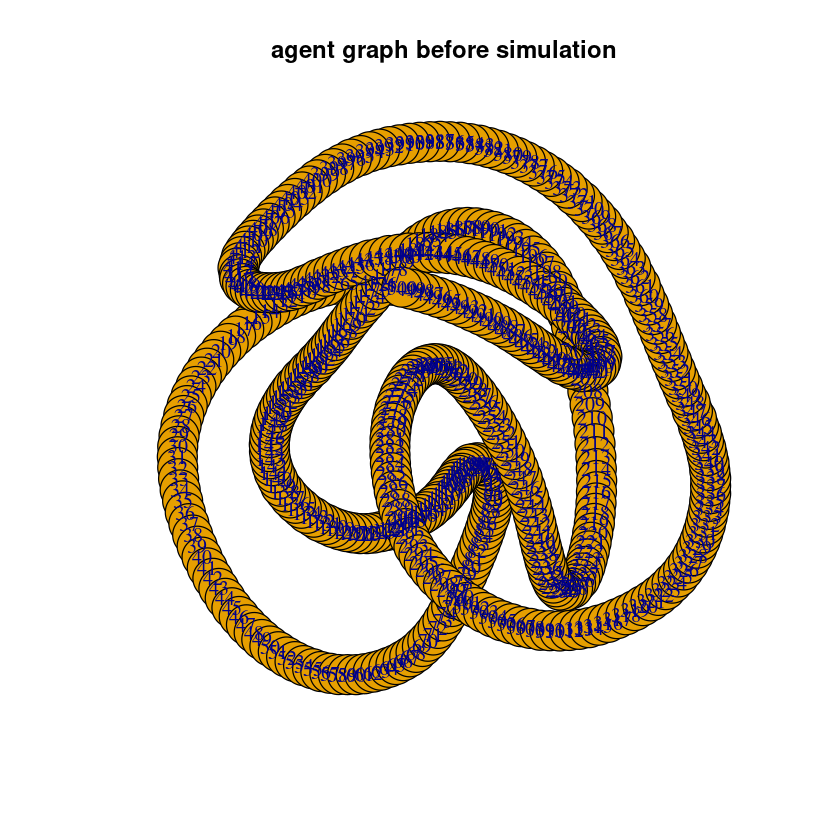



 Wealth of each agent:

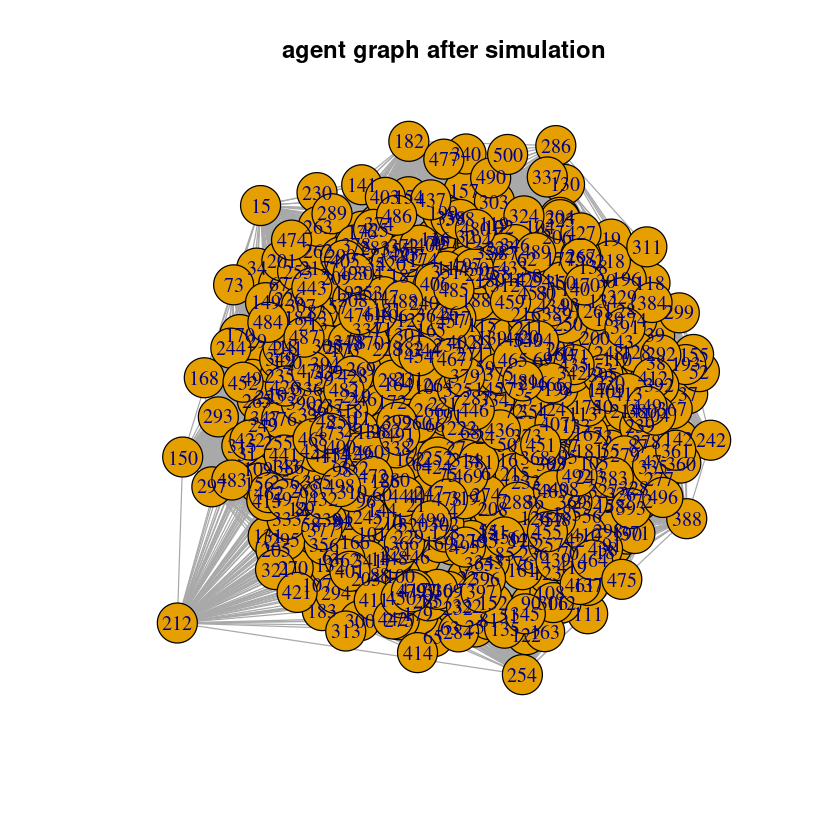



 Agent wealth histogram:

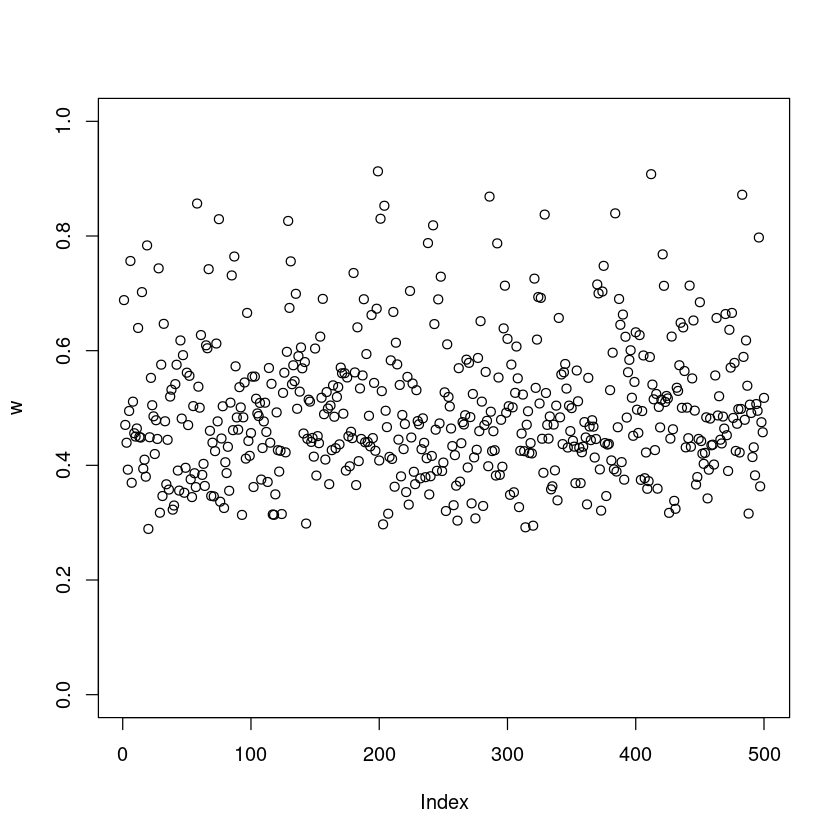



 Histogram data frame:       x   y
1  0.275   5
2  0.325  34
3  0.375  65
4  0.425 100
5  0.475  90
6  0.525  71
7  0.575  51
8  0.625  28
9  0.675  22
10 0.725  14
11 0.775   8
12 0.825   6
13 0.875   4
14 0.925   2

 x =  0.275 0.325 0.375 0.425 0.475 0.525 0.575 0.625 0.675 0.725 0.775 0.825 0.875 0.925

 y =  5 34 65 100 90 71 51 28 22 14 8 6 4 2


 In wr_analysis:
 x =  0.275 0.325 0.375 0.425 0.475 0.525 0.575 0.625 0.675 0.725 0.775 0.825 0.875 0.925
 y =  5 34 65 100 90 71 51 28 22 14 8 6 4 2

 Initial parameters for curve fitting:
 aa =  80 
 dx =  0.26 
 x0 =  0.16
 Still in wr_analysis:
 xfit.1 =  0 0.01010101 0.02020202 0.03030303 0.04040404 0.05050505 0.06060606 0.07070707 0.08080808 0.09090909 0.1010101 0.1111111 0.1212121 0.1313131 0.1414141 0.1515152 0.1616162 0.1717172 0.1818182 0.1919192 0.2020202 0.2121212 0.2222222 0.2323232 0.2424242 0.2525253 0.2626263 0.2727273 0.2828283 0.2929293 0.3030303 0.3131313 0.3232323 0.3333333 0.3434343 0.3535354 0.3636364 0.3737374 0

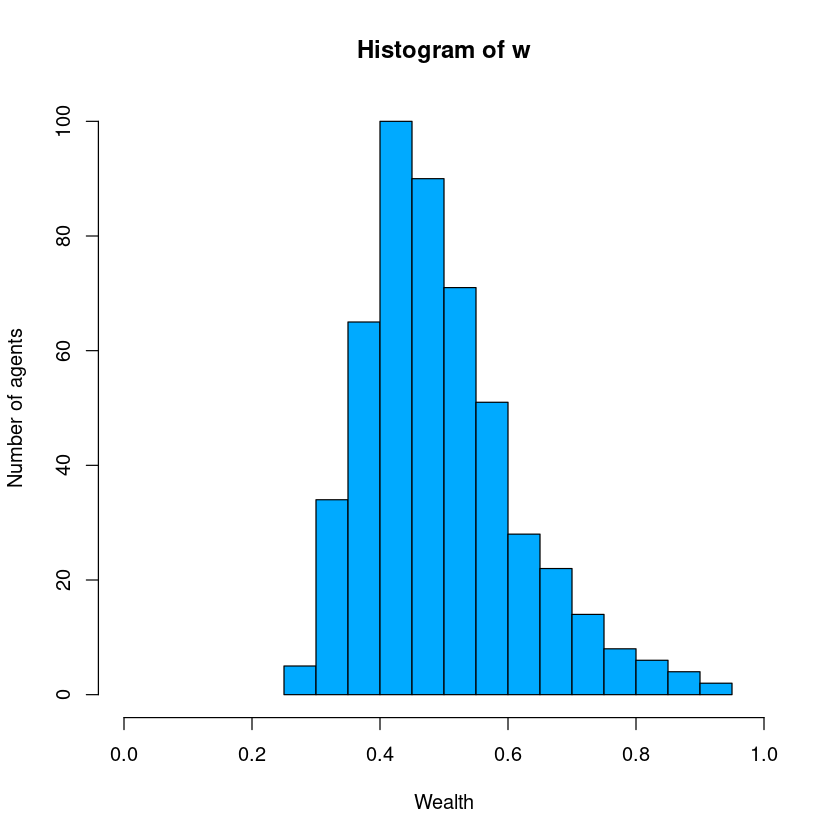



 Final adjusted parameters:
 aa =  138.5724 
 x0 =  0.3070627 
 dx =  0.2260916


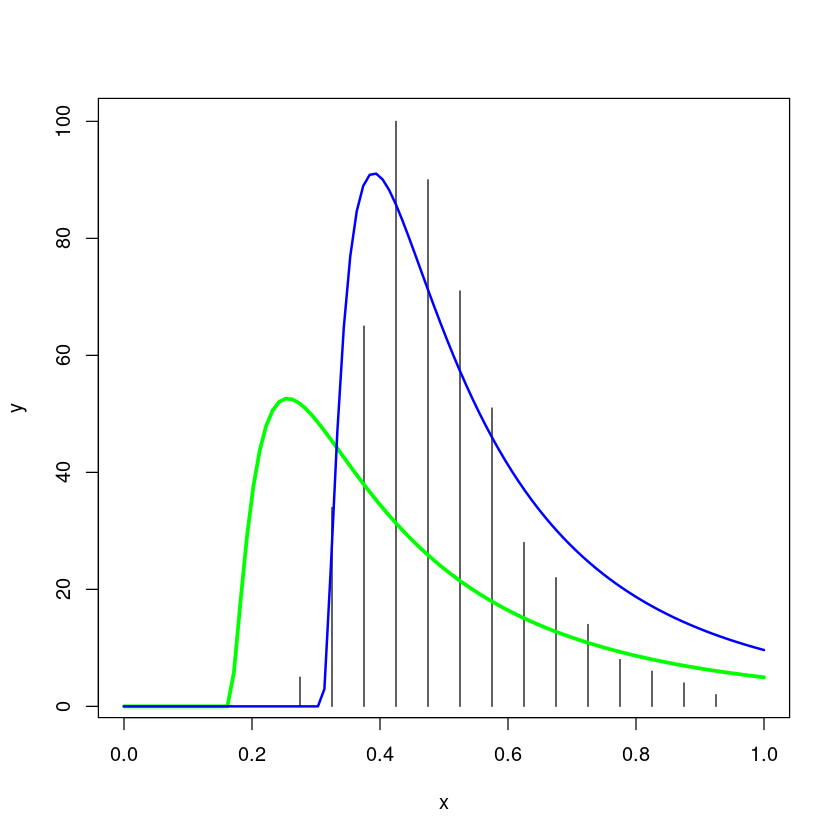


 Program WR

 Simulation initiated with the following parameters:
 Number of agents: n_agents =  500
 Number of iterations: n_iter =  5000
 Number of bits of activity representation: n_bits =  20
 Connection range (half the vertex degree) k =  2
 Tolerance of number of irregular bits: tol_n_irreg_bits =  5
 Punishment probability: p_pun =  0.1
 Punishment force: f_pun =  0.1
     (Fraction of wealth subtracted from punished agent.)
 Even wealth redistribution: even_redist =  TRUE
 Wealth production: wealth_prod =  FALSE
 Wealth produced per connection per iteration: wealth_prod_per_con_per_iter =  0.01
 Number of histogram bars: hist_breaks =  20
 Program debug information: debug =  FALSE
 Program stops: stop =  FALSE

 Creating initial network...
 Performing iterations...


 Now on iteration  500  of  5000 .


 Now on iteration  1000  of  5000 .


 Now on iteration  1500  of  5000 .


 Now on iteration  2000  of  5000 .


 Now on iteration  2500  of  5000 .


 Now on iteration  3000 

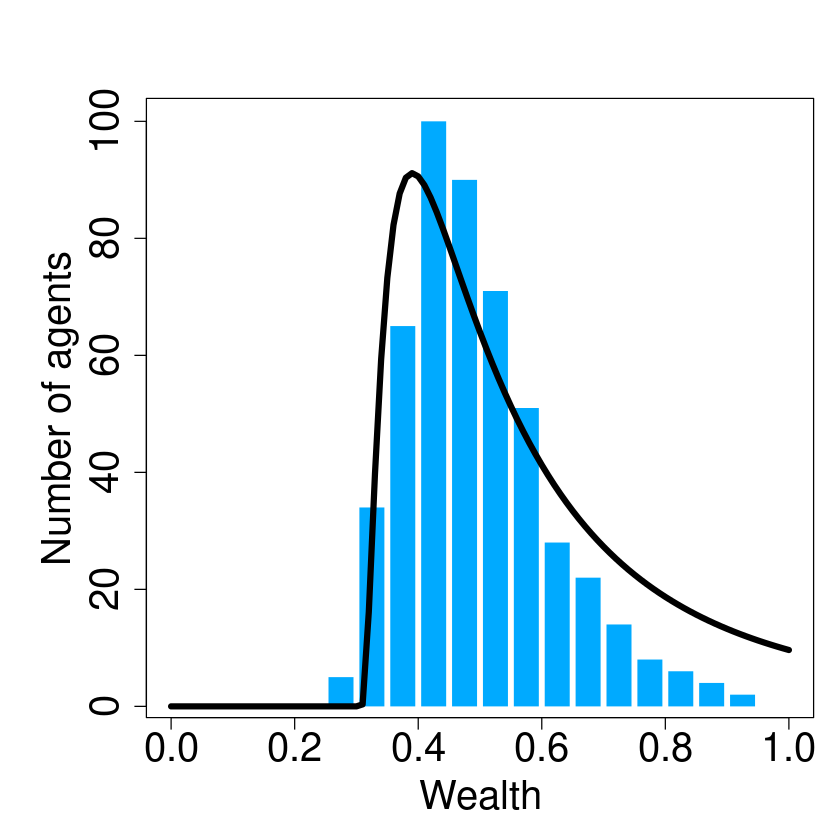


 Wealth of poorest agent: w_min =  0.2991927
 Index of instability: index_inst =  0.08311395
 Index of economic activity: econ_act =  167
 Index of wealth: index_wealth =  0.5095292
 Index of cooperation: index_coop =  0.5969379
 Index of harmony: index_harmony =  0.02025031

 w =  0.5169123 0.3356691 1.023224 0.4861134 0.4705523 0.4407508 0.3338999 0.5663496 0.3832545 0.395683 0.8430046 0.4067264 0.420188 0.6340761 0.5568117 0.3844543 0.5934646 0.5199096 0.5006375 0.8761485 0.3881468 0.5441608 0.5434514 0.5240835 0.6104782 0.395738 0.4115945 0.5286059 0.6876451 0.3931905 0.4020985 0.5941354 0.674884 0.5284376 0.4551409 0.4193402 0.6144264 0.4635032 0.5689991 0.4047691 1.0119 0.4399723 0.5751754 0.3908018 0.3720382 0.4242652 0.3148267 0.4875055 0.5399357 0.3645982 0.5316952 0.5583895 0.3714406 0.6182644 0.6567294 0.5440483 0.7148057 0.5060563 0.4159012 0.5005431 0.667768 0.4309568 0.3713702 0.3966762 0.513163 0.3678517 0.5048994 0.5231676 0.4935326 0.3743481 0.4430241 0.4694435 0.6969

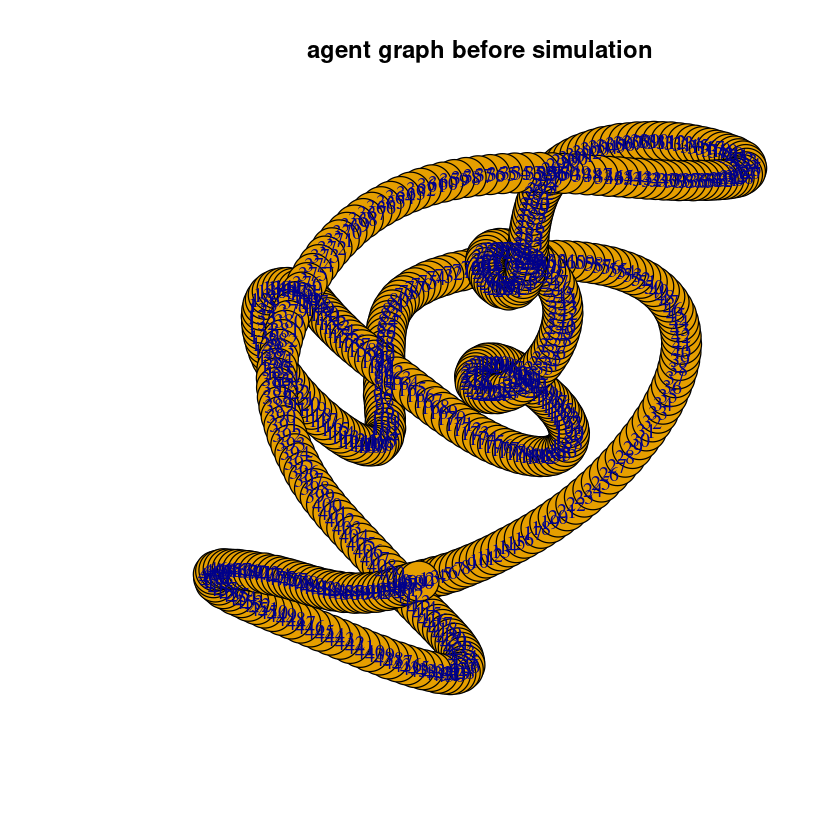



 Wealth of each agent:

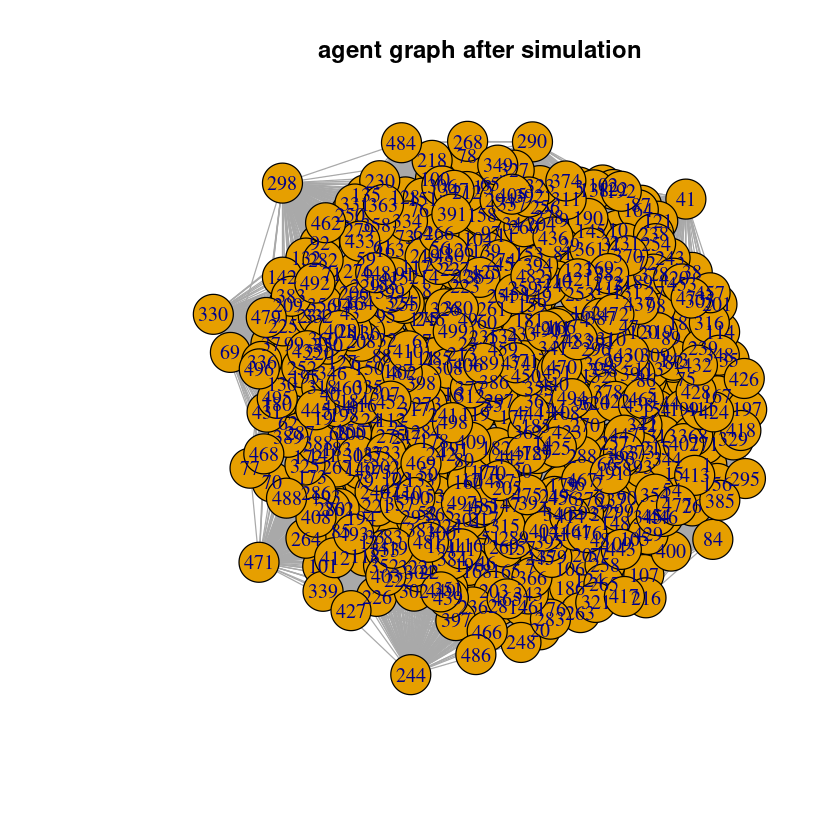



 Agent wealth histogram:

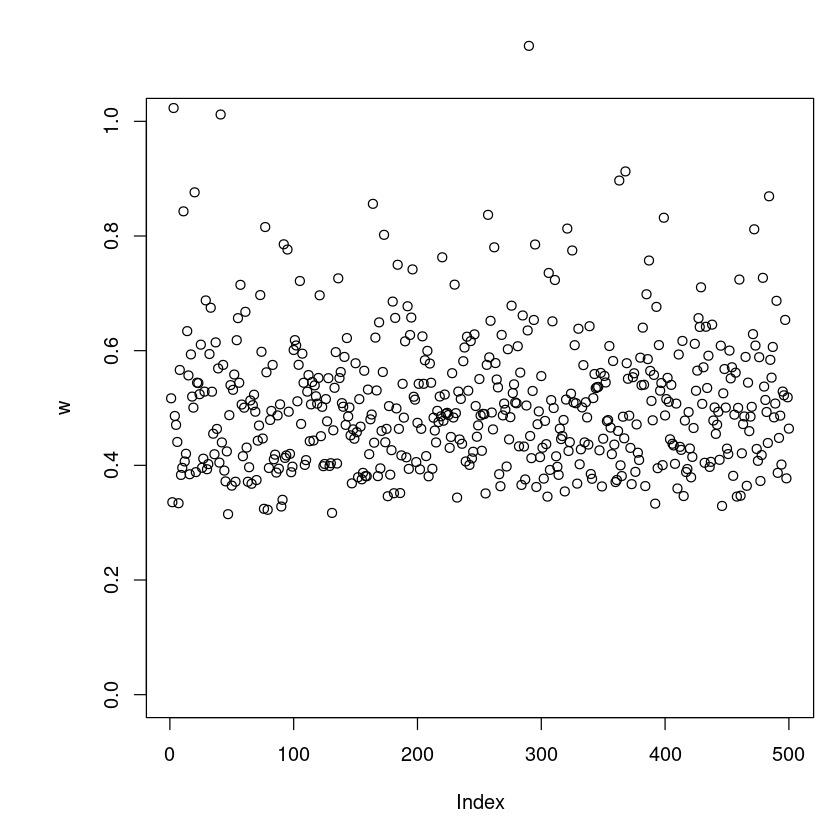



 Histogram data frame:       x  y
1  0.325 16
2  0.375 69
3  0.425 90
4  0.475 84
5  0.525 92
6  0.575 59
7  0.625 37
8  0.675 20
9  0.725 11
10 0.775  7
11 0.825  7
12 0.875  4
13 0.925  1
14 0.975  0
15 1.025  2
16 1.075  0
17 1.125  1

 x =  0.325 0.375 0.425 0.475 0.525 0.575 0.625 0.675 0.725 0.775 0.825 0.875 0.925 0.975 1.025 1.075 1.125

 y =  16 69 90 84 92 59 37 20 11 7 7 4 1 0 2 0 1


 In wr_analysis:
 x =  0.325 0.375 0.425 0.475 0.525 0.575 0.625 0.675 0.725 0.775 0.825 0.875 0.925 0.975 1.025 1.075 1.125
 y =  16 69 90 84 92 59 37 20 11 7 7 4 1 0 2 0 1

 Initial parameters for curve fitting:
 aa =  80 
 dx =  0.26 
 x0 =  0.16
 Still in wr_analysis:
 xfit.1 =  0 0.01010101 0.02020202 0.03030303 0.04040404 0.05050505 0.06060606 0.07070707 0.08080808 0.09090909 0.1010101 0.1111111 0.1212121 0.1313131 0.1414141 0.1515152 0.1616162 0.1717172 0.1818182 0.1919192 0.2020202 0.2121212 0.2222222 0.2323232 0.2424242 0.2525253 0.2626263 0.2727273 0.2828283 0.2929293 0.3030303 0.31

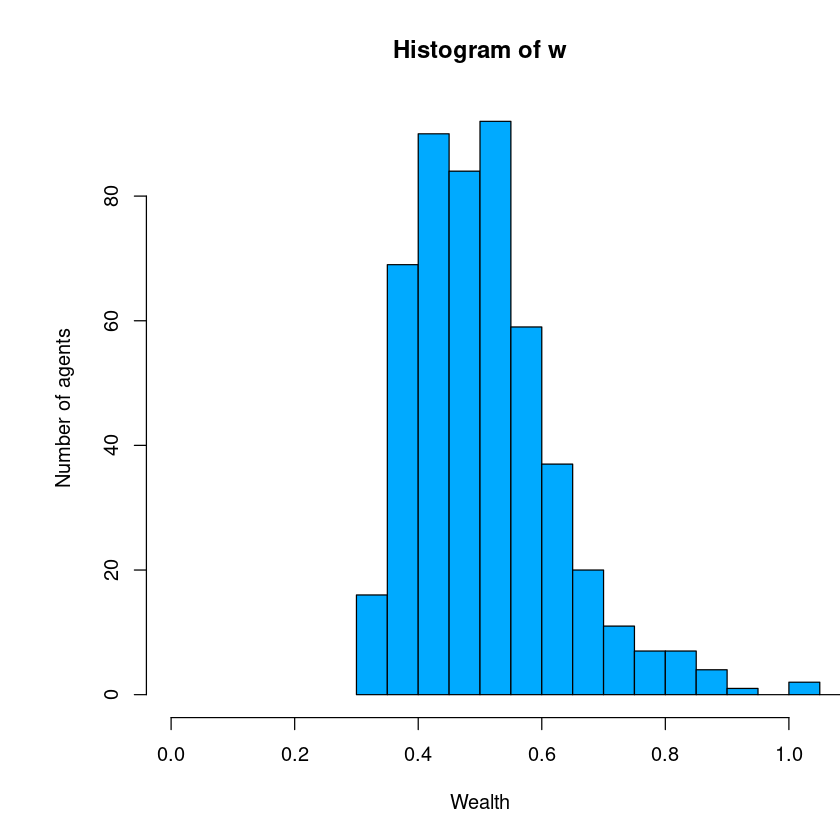



 Final adjusted parameters:
 aa =  139.4376 
 x0 =  0.3161464 
 dx =  0.2253313


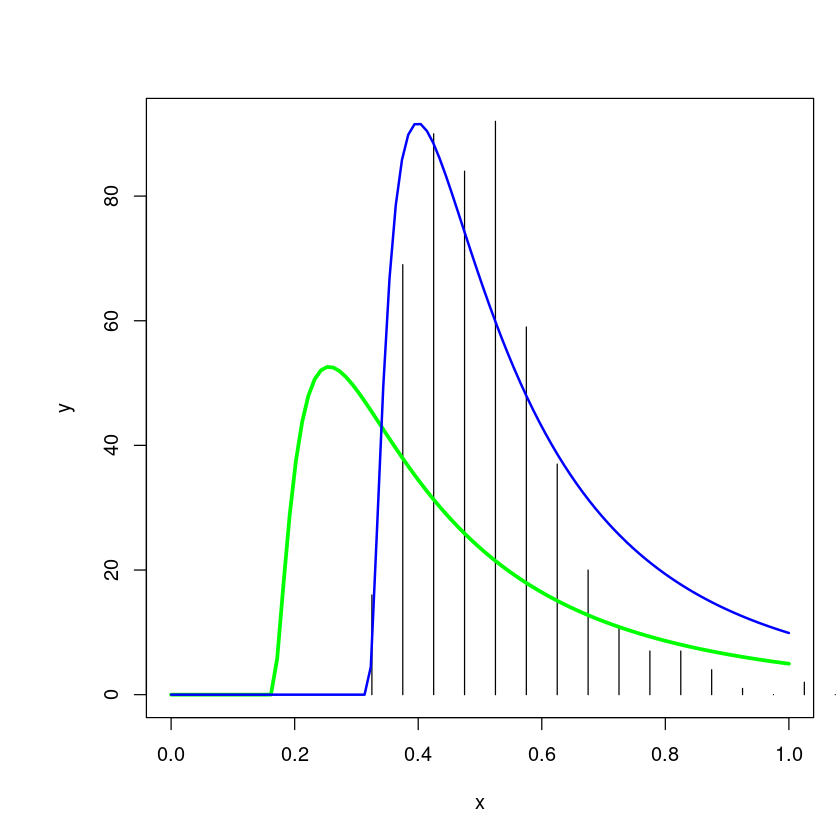


 Program WR

 Simulation initiated with the following parameters:
 Number of agents: n_agents =  500
 Number of iterations: n_iter =  5000
 Number of bits of activity representation: n_bits =  20
 Connection range (half the vertex degree) k =  2
 Tolerance of number of irregular bits: tol_n_irreg_bits =  5
 Punishment probability: p_pun =  0.1
 Punishment force: f_pun =  0.1
     (Fraction of wealth subtracted from punished agent.)
 Even wealth redistribution: even_redist =  TRUE
 Wealth production: wealth_prod =  FALSE
 Wealth produced per connection per iteration: wealth_prod_per_con_per_iter =  0.01
 Number of histogram bars: hist_breaks =  20
 Program debug information: debug =  FALSE
 Program stops: stop =  FALSE

 Creating initial network...
 Performing iterations...


 Now on iteration  500  of  5000 .


 Now on iteration  1000  of  5000 .


 Now on iteration  1500  of  5000 .


 Now on iteration  2000  of  5000 .


 Now on iteration  2500  of  5000 .


 Now on iteration  3000 

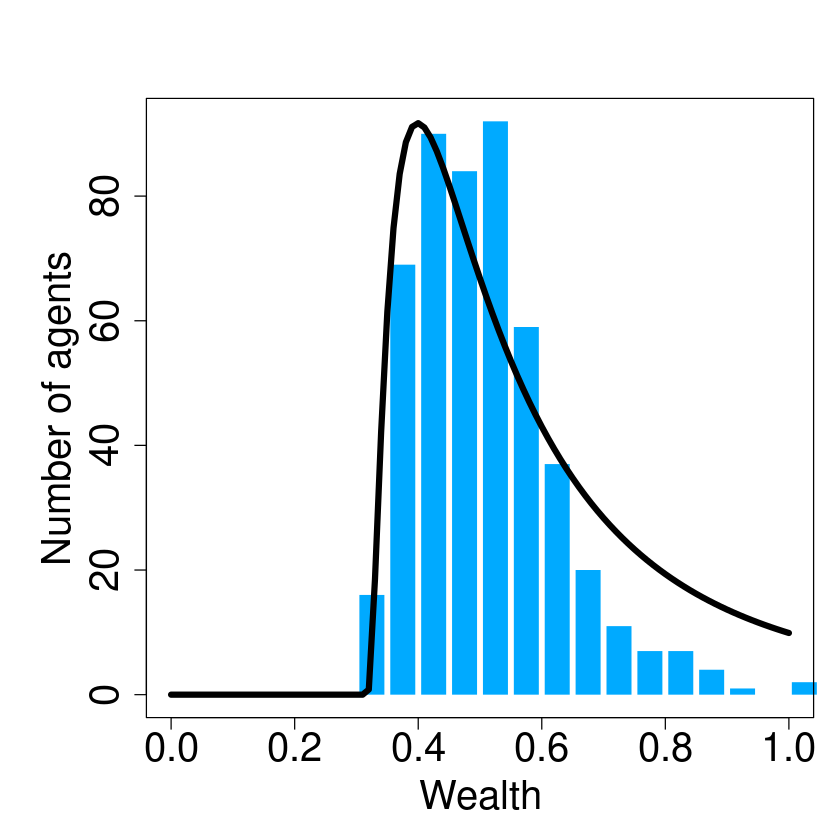


 Wealth of poorest agent: w_min =  0.2961594
 Index of instability: index_inst =  0.07044152
 Index of economic activity: econ_act =  156
 Index of wealth: index_wealth =  0.507284
 Index of cooperation: index_coop =  0.5942365
 Index of harmony: index_harmony =  0.018211

 w =  0.5173605 0.50751 0.5737703 0.5077451 0.3926957 0.3686902 0.503043 0.4499038 0.3440583 0.8043838 0.426058 0.3581026 0.4705492 0.3473193 0.5414429 0.7897425 0.5184641 0.6318659 0.5511773 0.4556372 0.4552797 0.3659599 0.5892282 0.3712219 0.5222479 0.3680699 0.459242 0.5146118 0.5804801 0.641573 0.4342819 0.561289 0.4120939 0.4493946 0.4947623 0.5197677 0.429423 0.5184916 0.4907107 0.5931909 0.3859054 0.8721608 0.4166862 0.600072 0.886832 0.5737815 0.4712499 0.965744 0.3641511 0.453074 0.5119534 0.6383451 0.6471528 0.5257635 0.3520319 0.7665275 0.4070153 0.3959289 0.6811313 0.3766327 0.3686973 0.4633028 0.5650012 0.6125037 0.4658927 0.4578143 0.5587555 0.4903366 0.3817823 0.458857 0.5681863 0.5240512 0.5720018 0.

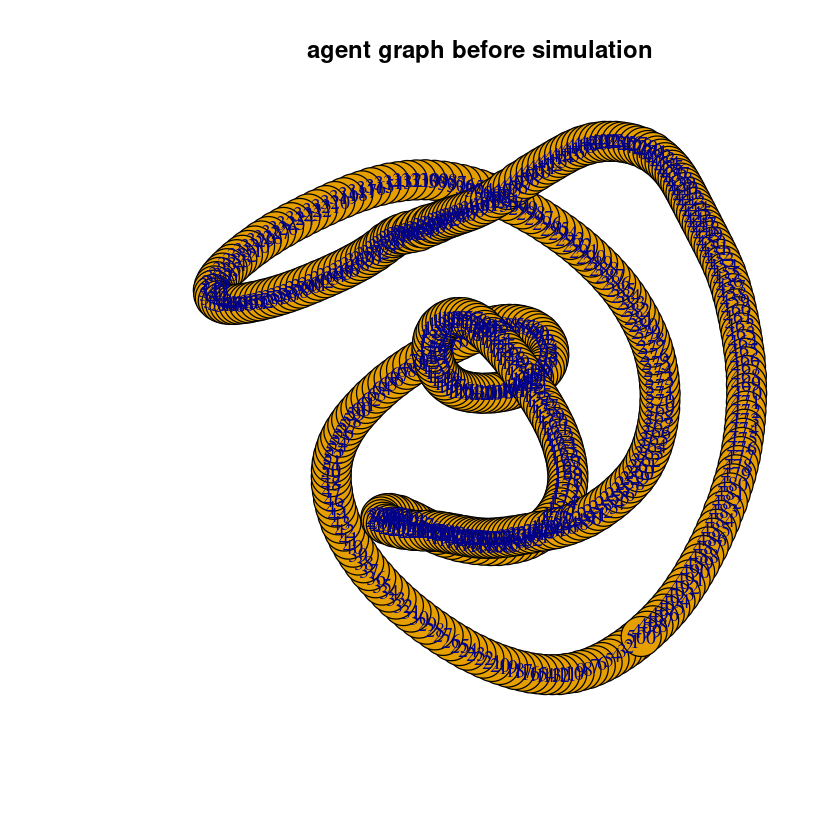



 Wealth of each agent:

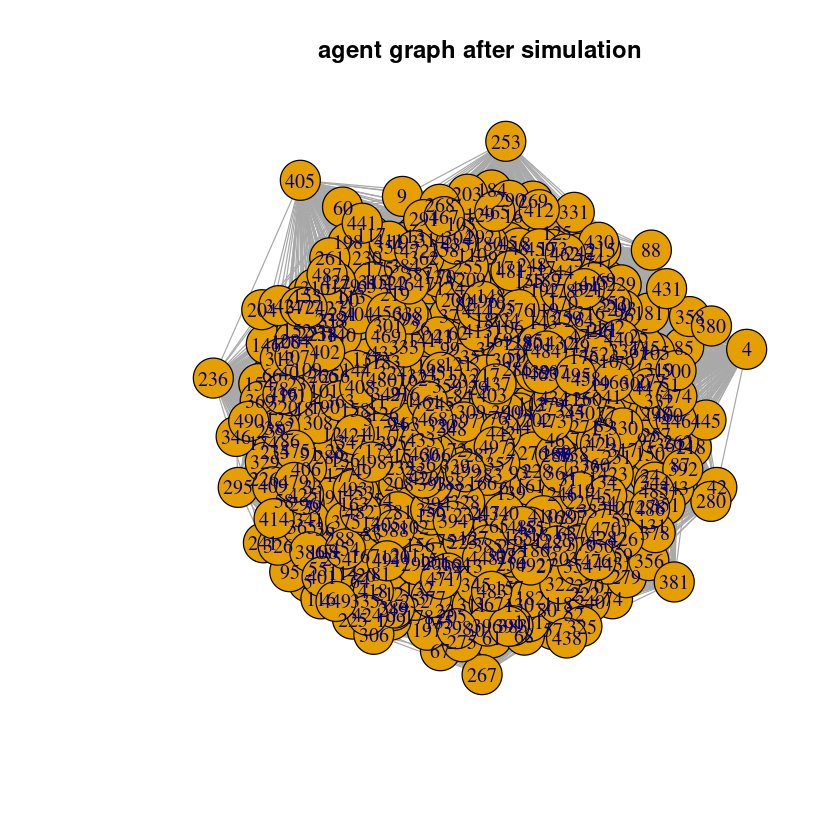



 Agent wealth histogram:

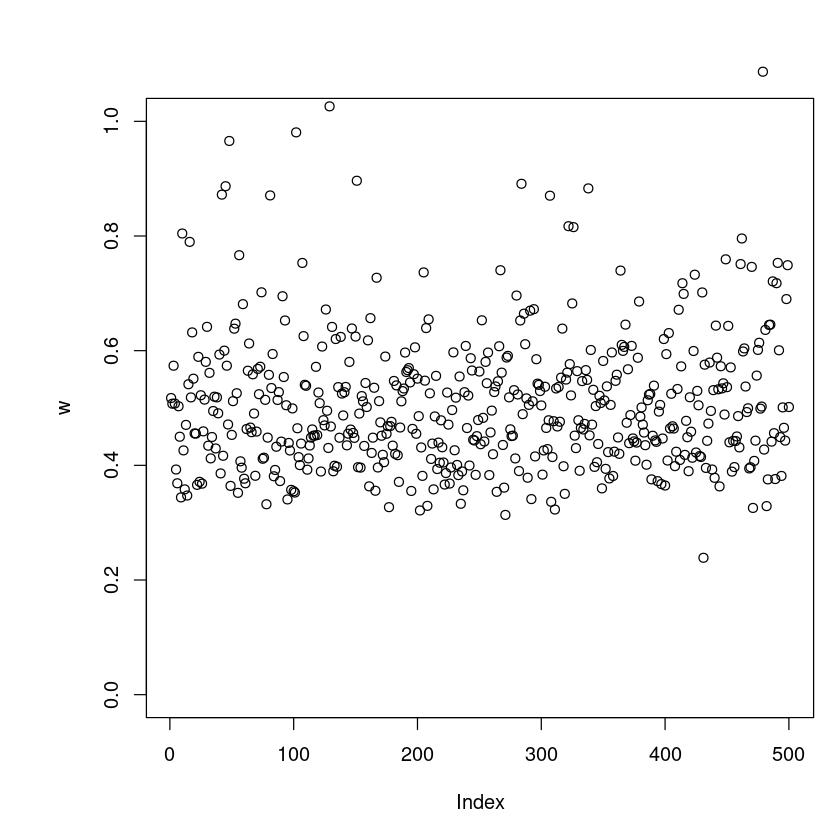



 Histogram data frame:       x  y
1  0.225  1
2  0.275  0
3  0.325 14
4  0.375 74
5  0.425 90
6  0.475 86
7  0.525 93
8  0.575 56
9  0.625 36
10 0.675 17
11 0.725 12
12 0.775  7
13 0.825  3
14 0.875  7
15 0.925  0
16 0.975  2
17 1.025  1
18 1.075  1

 x =  0.225 0.275 0.325 0.375 0.425 0.475 0.525 0.575 0.625 0.675 0.725 0.775 0.825 0.875 0.925 0.975 1.025 1.075

 y =  1 0 14 74 90 86 93 56 36 17 12 7 3 7 0 2 1 1


 In wr_analysis:
 x =  0.225 0.275 0.325 0.375 0.425 0.475 0.525 0.575 0.625 0.675 0.725 0.775 0.825 0.875 0.925 0.975 1.025 1.075
 y =  1 0 14 74 90 86 93 56 36 17 12 7 3 7 0 2 1 1

 Initial parameters for curve fitting:
 aa =  80 
 dx =  0.26 
 x0 =  0.16
 Still in wr_analysis:
 xfit.1 =  0 0.01010101 0.02020202 0.03030303 0.04040404 0.05050505 0.06060606 0.07070707 0.08080808 0.09090909 0.1010101 0.1111111 0.1212121 0.1313131 0.1414141 0.1515152 0.1616162 0.1717172 0.1818182 0.1919192 0.2020202 0.2121212 0.2222222 0.2323232 0.2424242 0.2525253 0.2626263 0.2727273 0.2828

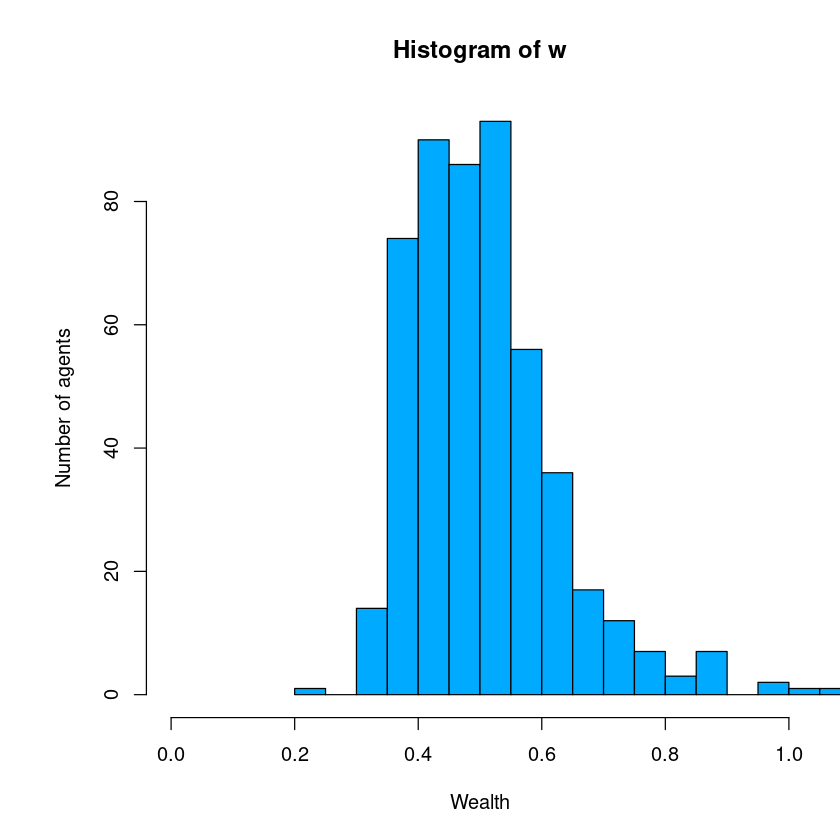



 Final adjusted parameters:
 aa =  161.1302 
 x0 =  0.3486025 
 dx =  0.1736442


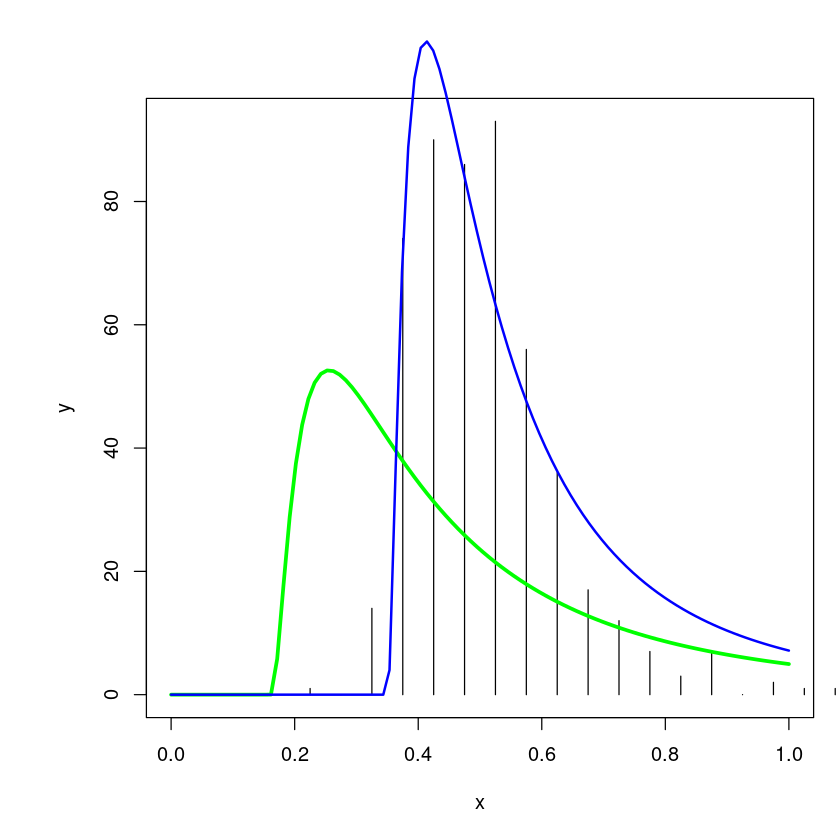

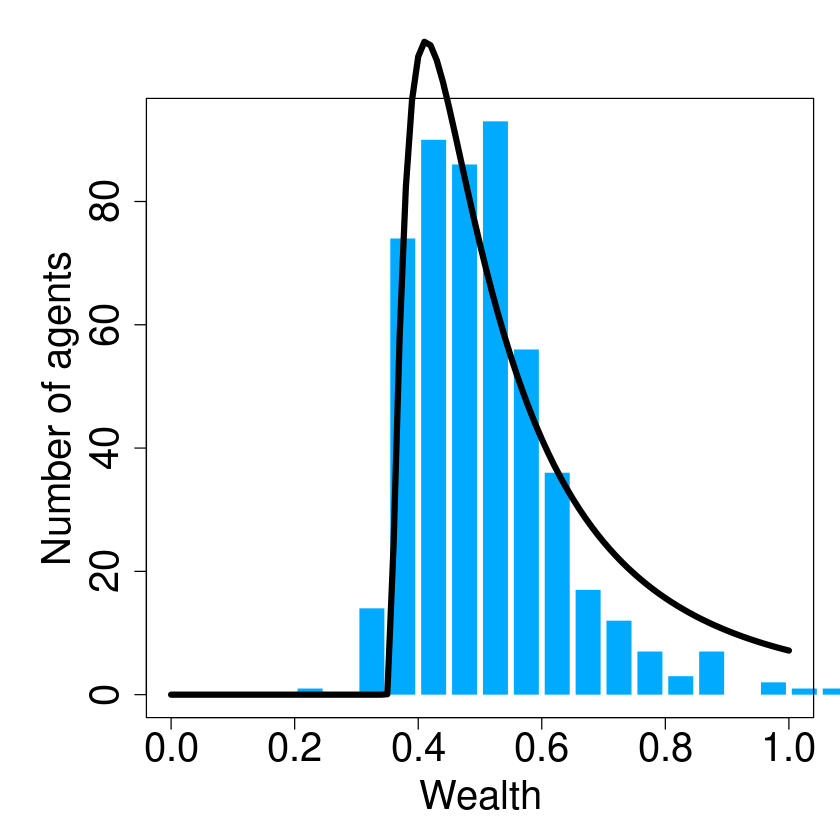

In [5]:
# Standard parameter values:
IN_n = 500 # 500
IN_n_iter = 5000 # 2000
IN_n_bits = 20
IN_k = 2
IN_tol_n_irreg_bits = 5
IN_p_pun = 0.1
IN_f_pun = 0.1
IN_even_redist = TRUE
IN_wealth_prod = FALSE
IN_wealth_prod_per_con_per_iter = 0.01
IN_hist_breaks = 20
IN_debug = FALSE
IN_stop = FALSE

# Current working directory:
cwd <- getwd()

# Altered parameter values:
IN_even_redist = TRUE

#for (IN_p_pun in c(0.0, 0.1, 0.3, 0.5, 0.7, 0.9))
#{
for (repetition in c(1, 2, 3))
{
    wr_binary_simulation(IN_n, IN_n_iter, IN_n_bits, IN_k, IN_tol_n_irreg_bits, IN_p_pun, IN_f_pun, IN_even_redist, IN_wealth_prod, IN_wealth_prod_per_con_per_iter, IN_hist_breaks, IN_debug, IN_stop)
}
#}